**Data Transforms**

    1. A) Obtain the MNIST and Galaxy datasets

Let's load the data!

In [1]:
import numpy as np
mnist = np.load('mnist.npz')
images = mnist['X']
labels = mnist['y']

    1. B) Explore the dataset by plotting some sample images, as we will use this also for future exercises

"images" contain a list of images, and "labels" contain the corresponding labels. Let's try to plot the first 25 images.

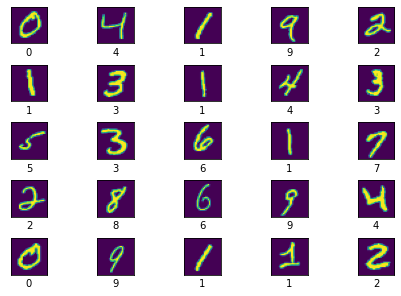

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
n = 5
fig, ax = plt.subplots(n, n, constrained_layout=True)
image_number = 0
for i in range(n):
    for j in range(n):
        image_number += 1
        ax[i][j].imshow(images[image_number].reshape(28,28))
        # hide y-axis 
        ax[i][j].get_yaxis().set_visible(False)
        # remove x-axis ticks
        ax[i][j].xaxis.set_major_locator(ticker.NullLocator())
        # write image label as x axis label
        ax[i][j].set_xlabel(labels[image_number])


    2. A) Asses the covariance / correlation structure of the dataset ( Since large matricies are hard to print out, you can try graphical representations, such as color maps)
    
Let's plot the covariance between pixels.

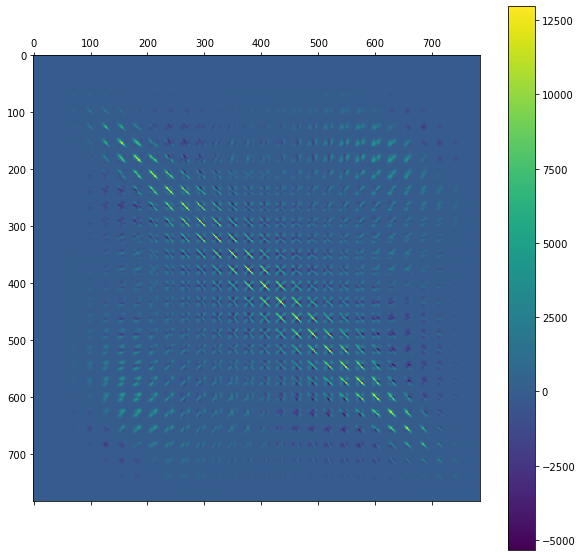

In [3]:
import seaborn as sn
import numpy as np
covMatrix = np.cov(images.T)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(covMatrix)
fig.colorbar(cax)

The plot above shows the covariance matrix. The structure is characteristic for images. Let's try to zoom in on pixels 100:150

(150.0, 100.0)

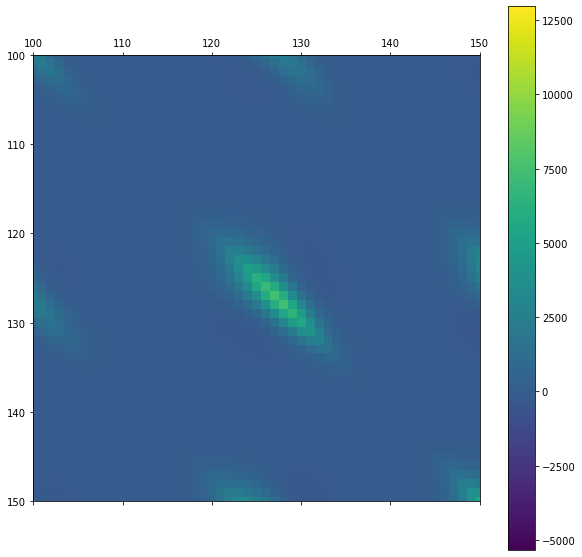

In [4]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(covMatrix)
fig.colorbar(cax)
plt.xlim([100,150])
plt.ylim([150,100])

So the covariance seems to be 0 between pixels 110 and 120. Lets check these pixels for an image by plotting the image where any other pixel is masked with a yellowish padding color. 

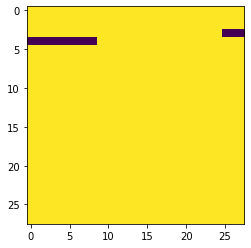

In [5]:
from copy import deepcopy
images_sliced = deepcopy(images)
pad_color = 255
images_sliced.shape
images_sliced[:,0:109] = pad_color
images_sliced[:,121:] = pad_color
plt.imshow(images_sliced[0].reshape(28,28))

Alright - so the pixels with near 0 covariance seems to be pixels that make up the sides of the images. These are the parts of the image that rarely have any color, as the images we work with are centered. Let's check the pixel values of these and compare with pixels closer to the center. 

In [6]:
print(f'Pixels 110 to 120 : {images[:,110:120].mean()}')
print(f'Pixels 420 to 430 : {images[:,420:430].mean()}')  

Pixels 110 to 120 : 0.3959985714285714
Pixels 420 to 430 : 25.73164


    2. B) Use one of the techniques discussed in the lecture (Eigen, Cholesky or SVD)
    
Lets start with the eigenvalue technique by using the code snippet from Philipps slides.

In [7]:
from scipy.linalg import eig
eigen_entries, e = eig(covMatrix)
eig_images = images @ e.T

Let's see how this transformation changed image number 0. 

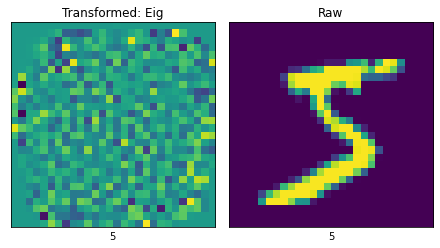

In [8]:

image_number = 0
fig, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].imshow(eig_images[image_number].reshape(28,28))
ax[1].imshow(images[image_number].reshape(28,28))
ax[0].set_title('Transformed: Eig')
ax[1].set_title('Raw')
for axis in ax:
    axis.set_xlabel(labels[image_number])
    # hide y-axis 
    axis.get_yaxis().set_visible(False)
    # remove x-axis ticks
    axis.xaxis.set_major_locator(ticker.NullLocator())
    


Let's plot the covariance matrix for the transformed pixel values. If we have done it right, the results should look quite diagonal.

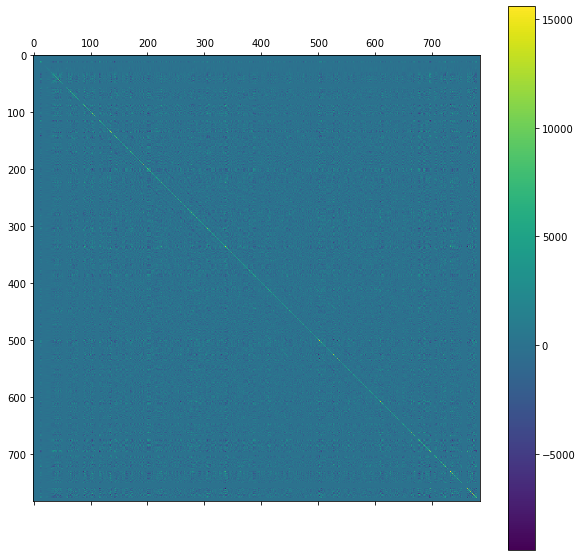

In [9]:
covMatrix_eig = np.cov(eig_images.T,bias=True)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(covMatrix_eig)
fig.colorbar(cax)

OK. Looks good. Now let's try Cholesky Whitening. Again, from the slides we have

In [10]:
inv_covMatrix = np.linalg.inv(covMatrix)
l = np.linalg.cholesky(inv_covMatrix)
images_cholesky = l.T @ images.T

LinAlgError: Singular matrix

Oh! Seems like our covariance matrix is not invertible. A square matrix is only invertible if all eigenvalues are non-zero. Let's count zero eigenvalues in "eigen_entries"

In [11]:
sum(eigen_entries==0)

65

Alright. Let's try Single Value Decoposition - here is a nice visual tutorial on SVD: https://towardsdatascience.com/essential-math-for-data-science-visual-introduction-to-singular-value-decomposition-svd-ca549ab7eb9c

In [19]:
images_demeaned = (images - images.mean(axis = 0)) 
U, S, V = np.linalg.svd(images_demeaned)


In [20]:
images_projected = np.matmul(images_demeaned, V.T)

In [21]:
images_scaled = np.multiply(images_projected, (1 / S))

In [22]:
images_unrotated = np.matmul(images_scaled, V)

In [24]:
images_svd = V@images_demeaned.T

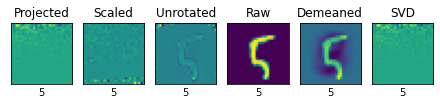

In [25]:
image_number = 100
fig, ax = plt.subplots(1, 6, constrained_layout=True)
ax[0].imshow(images_projected[image_number].reshape(28,28))
ax[0].set_title('Projected')
ax[1].imshow(images_scaled[image_number].reshape(28,28))
ax[1].set_title('Scaled')
ax[2].imshow(images_unrotated[image_number].reshape(28,28))
ax[2].set_title('Unrotated')
ax[3].imshow(images[image_number].reshape(28,28))
ax[3].set_title('Raw')
ax[4].imshow(images_demeaned[image_number].reshape(28,28))
ax[4].set_title('Demeaned')
ax[5].imshow(images_svd.T[image_number].reshape(28,28))
ax[5].set_title('SVD')
for axis in ax:
    axis.set_xlabel(labels[image_number])
    # hide y-axis 
    axis.get_yaxis().set_visible(False)
    # remove x-axis ticks
    axis.xaxis.set_major_locator(ticker.NullLocator())

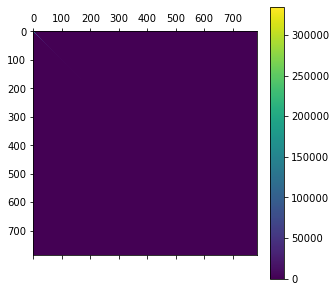

In [27]:
covMatrix_svd  = np.cov(images_svd)
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
cax = ax.matshow(covMatrix_svd)
fig.colorbar(cax)

Alright. Let's try to zoom in and see whats going on.

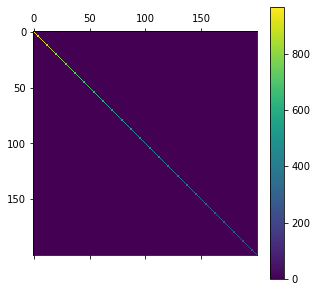

In [28]:
covMatrix_svd  = np.cov(images_svd)
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
cax = ax.matshow(covMatrix_svd[200:400, 200:400])
fig.colorbar(cax)